### 通过张正友标定法获取相机参数

#### 步骤

```
1.准备标定板：使用一个已知尺寸的标定板（通常是黑白棋盘格），并在标定板上标记出若干个特征点。
2.拍摄图像：将标定板放置在不同的位置姿态下拍摄多张图像，并记录每张图像对应的相机姿态（即相机位姿）。
3.提取角点：对每张图像进行角点提取，即找到标定板上的特征点在图像中的对应位置。
4.计算相机姿态：通过已知的标定板尺寸和提取的角点，计算每张图像对应的相机位姿。
5.标定相机：使用相机标定公式，计算出相机的内参矩阵和畸变系数。
6.评估标定结果：使用标定结果评估指标（如重投影误差）来评估标定结果的准确性。
需要注意的是，该方法需要至少使用10张以上的图像才能稳健地标定相机。此外，标定板的布局和大小也会对标定结果产生影响。
```

#### 注意

```
1.标定板的质量：标定板需要具有较高的精度和稳定性，以保证提取的角点准确无误。同时，在摄影过程中需要避免标定板发生变形或损坏。
2.角点提取算法：角点提取算法需要能够精确地检测到标定板上的特征点，并且对噪声和光照变化具有一定的鲁棒性。目前常用的角点提取算法包括Harris角点算法、Shi-Tomasi算法等。
3.图像采集：在采集图像时，应尽可能保持相机姿态的多样性和分布均匀性，以覆盖尽可能广泛的空间。
4.相机位姿的估计：相机位姿的估计需要具有一定的精度和可靠性。通常可以使用三维-二维点对求解相机姿态，也可以使用直接法等方法进行位姿估计。
5.重投影误差的评估：重投影误差是评估标定结果好坏的一个重要指标。在评估时，需要注意将误差控制在一定范围内，同时了解误差来源，以便对标定结果进行进一步优化。
6.畸变校正的效果：畸变是相机成像过程中不可避免的问题，需要进行畸变校正。在进行畸变校正时，需要注意调整参数以达到最佳校正效果，并对校正结果进行评估和验证。
```


In [9]:
# 导包
import os
import cv2
import numpy as np


In [10]:
# 定义棋盘格模板规格:只算内角点个数,不算最外面的一圈点
pattern_size = (11, 8)
# 定义每个棋盘格的物理尺寸（单位：毫米）
square_size = 40.0
# 图像所在文件夹的位置
original_images = './CalibrationPlate/original/'   # 原始图片保存位置
resize_images = './CalibrationPlate/resize/'   # 调整尺寸后的图像保存位置
corner_images = './CalibrationPlate/corner/'   # 显示角点的图像保存位置


In [11]:
"""_调整图片大小,防止图片过大引起崩溃_
Args:
    input (_string_): _输入图片的文件夹路径_
    output (_string_): _输出图片的文件夹路径_
    width (_int_): _输出图片宽度_
    height (_int_): _输出图片高度_
"""


def ResizeImage(input, output, width, height):
    Images = os.listdir(input)
    for fname in Images:
        image = cv2.imread(input + fname)
        out = cv2.resize(image, (width, height))
        cv2.imwrite(output + fname, out)


In [12]:
# 调整图片尺寸
new_width = 800
new_height = 600
ResizeImage(original_images, resize_images, new_width, new_height)


In [13]:
# 世界坐标系中的棋盘格点,例如(0,0,0),(2,0,0)...(8,5,0)，去掉Z坐标，记为二维矩阵
world_point = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
# 将世界坐标系建在标定板上，所有点的Z坐标全部为0，所以只需要赋值x和y
world_point[:, :2] = np.mgrid[0:pattern_size[0]*square_size:square_size,
                              0:pattern_size[1]*square_size:square_size].T.reshape(-1, 2)
# 储存棋盘格角点的世界坐标和图像坐标对
world_points = []  # 世界坐标系中的三维点
image_points = []  # 图像平面的二维点


In [14]:
"""
角点精准化迭代过程的终止条件:
第一项:表示迭代次数达到最大次数时停止迭代;
第二项:表示角点位置变化的最小值已经达到最小时停止迭代;
第三项和第四项：表示设置寻找亚像素角点的参数--采用的停止准则是最大循环次数30和最大误差容限0.001
"""
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30, 0.001)


In [15]:
images = os.listdir(resize_images)   # 读入图像序列
index = 0
for fname in images:
    image = cv2.imread(resize_images + '/' + fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # RGB转灰度
    # 寻找棋盘格角点,存放角点于corners中
    # 如果找到足够点对,将其存储起来,ret为非零值
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
    # 检测到角点后,进行亚像素级别角点检测,更新角点

    if ret == True:
        index += 1
        # 输入图像gray;角点初始坐标corners;搜索窗口为2*winsize+1;表示窗口的最小(-1.-1)表示忽略;求角点的迭代终止条件
        cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        world_points.append(world_point)   # 世界坐标
        image_points.append(corners)  # 图像坐标
        cv2.drawChessboardCorners(image, pattern_size, corners, ret)
        cv2.imwrite(corner_images + '/corners_' + str(index) + '.jpg', image)
        cv2.waitKey(10)
    cv2.destroyAllWindows()


In [16]:
"""
输入:世界坐标系里的位置;像素坐标;图像的像素尺寸大小;
输出:
    ret: 重投影误差;
    mtx: 内参矩阵;
    dist: 畸变系数;
    rvecs: 旋转向量 (外参数);
    tvecs: 平移向量 (外参数);
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    world_points, image_points, gray.shape[::-1], None, None)

# 保存相机参数(内参矩阵、畸变参数、旋转向量、平移向量)
np.savez('./Parameter/豪威OV48B_800x600.npz', mtx=mtx, dist=dist,
         rvecs=rvecs, tvecs=tvecs)  # 分别使用mtx,dist,rvecs,tvecs命名数组

print("ret(重投影误差):", ret,
      "\n\nmtx(内参矩阵):\n", mtx,
      "\n\ndist(畸变参数):\n", dist,  # 5个畸变参数,(k1,k2,p1,p2,k3)
      "\n\nrvecs(旋转向量):\n", rvecs,
      "\n\ntvecs(平移向量):\n", tvecs
      )


ret(重投影误差): 0.2991705035712761 

mtx(内参矩阵):
 [[596.34925072   0.         400.35710334]
 [  0.         596.49697012 300.47081541]
 [  0.           0.           1.        ]] 

dist(畸变参数):
 [[ 9.86732100e-02 -4.94565440e-01 -4.51708736e-04  2.89052555e-04
   8.22459145e-01]] 

rvecs(旋转向量):
 (array([[-0.0483275 ],
       [-0.05556281],
       [ 0.00805537]]), array([[-0.12482361],
       [ 0.15589444],
       [-0.07529847]]), array([[-0.17208193],
       [ 0.10014288],
       [-0.37814094]]), array([[-0.12937114],
       [ 0.11474067],
       [ 0.48904626]]), array([[0.30262844],
       [0.16153906],
       [0.03016236]]), array([[0.01218194],
       [0.56805057],
       [0.0150598 ]]), array([[-0.02910297],
       [-0.39260678],
       [-0.02031562]]), array([[-0.27239019],
       [-0.36934551],
       [ 0.12117097]]), array([[ 0.22883962],
       [-0.30550396],
       [-0.12688241]]), array([[ 0.06883582],
       [-0.27973277],
       [-0.06456626]]), array([[-0.2665373 ],
       [-0.185

### 生成指定要求的 ArUco 码并保存到 word 文件

#### 注意

```
假设每英寸96像素(即每个像素有0.0104英寸)，可以根据实际情况调整DPI值。在打印时，需要使用A4纸并选择“实际大小”或“100%”的缩放选项，以保持Aruco码的尺寸。
```


In [ ]:
# 导包
import cv2
import numpy as np
from docx import Document
from docx.shared import Inches


In [ ]:
# 创建Aruco码,输入参数为:行数、列数、Aruco码字典、标记长度、标距间距、码标
def create_aruco_markers(rows, cols, aruco_dict, marker_length, marker_separation, marker_ids):
    aruco_params = cv2.aruco.DetectorParameters_create()

    # 创建3D对象点数组：包含4个点的数组，用于定义标记的形状和大小
    obj_points = np.zeros((4, 3), dtype=np.float32)
    obj_points[:, :2] = np.array([[0, 0], [marker_length, 0], [
                                 marker_length, marker_length], [0, marker_length]])
    obj_points_array = [obj_points] * (rows * cols)

    # 创建Aruco板:使用上一步中定义的对象点数组、字典和记ID创建Aruco板
    aruco_board = cv2.aruco.Board_create(objPoints=obj_points_array,
                                         dictionary=aruco_dict,
                                         ids=marker_ids)
    img_size = (cols * (marker_length + marker_separation) + marker_separation,
                rows * (marker_length + marker_separation) + marker_separation)

    # 创建空白图像:根据行数、列数、标记长度和标记间距创建一个空白图像
    aruco_image = np.full(img_size, 255, dtype=np.uint8)

    # 绘制标记:遍历Aruco板中的每个标记,使用cv2.aruco.drawMarker函数绘制标记,并将其放置在空白图像中的相应位置
    for i, obj_points in enumerate(aruco_board.objPoints):
        marker_image = cv2.aruco.drawMarker(
            aruco_dict, marker_ids[i][0], marker_length)
        x = marker_separation + (i % cols) * \
            (marker_length + marker_separation)
        y = marker_separation + (i // cols) * \
            (marker_length + marker_separation)
        aruco_image[y:y + marker_length, x:x + marker_length] = marker_image

    # 返回包含所有标记的Aruco图像
    return aruco_image


In [ ]:
# 保存Aruco码标记到Word文件
def save_aruco_markers_to_word(doc, aruco_image, image_name, doc_name):
    # 使用cv2.imwrite函数将Aruco标记图像保存到指定的图像文件中
    cv2.imwrite(image_name, aruco_image)
    # 使用doc.add_picture函数将保存的图像文件插入到Word文档中，并指定图像的宽度和高度
    doc.add_picture(image_name, width=Inches(8.27), height=Inches(11.69))
    # 使用doc.save函数将修改后的Word文档保存到指定的文件中
    doc.save(doc_name)


In [ ]:
# 设置Aruco标记的参数
rows = 2    # 行数
cols = 3    # 列数
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)  # 字典
marker_length = 50  # 码标长度(单位：毫米)
marker_separation = 50  # 标记间距(单位：毫米)
marker_ids = np.array([[0], [1], [2], [3], [4], [5]]
                      ).reshape(rows, cols)  # 标记ID

# 将标记长度和标记间距从毫米转换为像素,假设每英寸96像素
dpi = 96
marker_length_pixels = int(marker_length * dpi / 25.4)
marker_se_pixels = int(marker_separation * dpi / 25.4)

# 生成Aruco码标记图像
aruco_image = create_aruco_markers(
    rows, cols, aruco_dict, marker_length_pixels, marker_separation_pixels, marker_ids)

# 保存Aruco码到Word文档中
doc = Document()
save_aruco_markers_to_word(
    doc, aruco_image, './ArucoGenerated/aruco_markers.png', './ArucoGenerated/aruco_markers.docx')


### 获取 Aruco 码中心点的像素坐标

#### 方法原理

```
检测所拍摄的含有ArUco标记的图像,先获取每一个Aruco四个角点的像素坐标,随后计算出中心点的像素坐标,并保存为列表。
```


In [54]:
# 导包
import os
import cv2
import csv
import numpy as np


In [55]:
# 指定文件夹路径
folder_path = "./ArucoShot/800x600/"
# 指定保存Aruco码中心点像素坐标的csv文件
csv_name = './ArucoShot/PixelCoordinates.csv'
# 使用默认值初始化检测器参数
parameters = cv2.aruco.DetectorParameters_create()
# 指定Aruco的字典参数
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)


In [56]:
# 写入csv文件时先清空其全部内容:使用w模式打开文件，然后再写入新的内容
with open(csv_name, mode="w", newline="", encoding="utf-8") as file:
    # 创建一个csv.writer对象来写入CSV格式数据
    writer = csv.writer(file)
    # 使用writerow()方法写入表头行
    writer.writerow(["ImageName", "ArucoId", "X", "Y"])
    # 遍历文件夹下的所有文件
    for filename in os.listdir(folder_path):
        # 判断文件是否为图片文件
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # 使用OpenCV读取图片
            image = cv2.imread(os.path.join(folder_path, filename))
            # 检测图像中的标记
            corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(
                image, dictionary, parameters=parameters)
            if ids is not None:
                print("\n在图像", filename, "中共检测出", len(ids), "个arUco码")
                # 计算每个标记的中心点
                for i in range(len(corners)):
                    # 获取当前标记的角
                    markerCorners = corners[i][0]
                    # 计算当前标记的中心点
                    center = np.mean(markerCorners, axis=0)
                    # 将坐标信息保存为列表
                    coordinate = [str(filename), int(
                        ids[i]), center[0], center[1]]
                    # 创建一个csv.writer对象来写入CSV格式数据
                    writer = csv.writer(file)
                    # 写入数据
                    writer.writerow(coordinate)
                    # 打印输出
                    print("coordinate:", coordinate)
            else:
                print("\n在图像", filename, "中未检测出ArUco码")



在图像 IMG_20230425_171500.jpg 中共检测出 6 个arUco码
coordinate: ['IMG_20230425_171500.jpg', 4, 405.25, 463.75]
coordinate: ['IMG_20230425_171500.jpg', 2, 366.25, 463.0]
coordinate: ['IMG_20230425_171500.jpg', 0, 327.0, 462.75]
coordinate: ['IMG_20230425_171500.jpg', 5, 403.75, 433.0]
coordinate: ['IMG_20230425_171500.jpg', 3, 366.75, 432.0]
coordinate: ['IMG_20230425_171500.jpg', 1, 329.5, 431.0]

在图像 IMG_20230426_110858.jpg 中共检测出 6 个arUco码
coordinate: ['IMG_20230426_110858.jpg', 4, 454.0, 486.5]
coordinate: ['IMG_20230426_110858.jpg', 2, 411.0, 484.0]
coordinate: ['IMG_20230426_110858.jpg', 0, 368.25, 481.0]
coordinate: ['IMG_20230426_110858.jpg', 5, 452.5, 452.5]
coordinate: ['IMG_20230426_110858.jpg', 3, 412.0, 450.0]
coordinate: ['IMG_20230426_110858.jpg', 1, 371.5, 447.25]


### 根据两幅图像上对应的四个点的世界坐标系下的点坐标和相机坐标系下的像素坐标来求其他点的世界坐标

#### 已知

```
1.两幅图像上对应的四个点的世界坐标系下的点坐标和相机坐标系下的像素坐标。
2.相机的内参矩阵和畸变系数。
```

#### 实现

```
使用立体视觉的方法：首先计算两个相机的姿态（旋转和平移矩阵），然后使用这些矩阵和相机内参矩阵进行三角测量以获取其他点的世界坐标。
```


In [21]:
# 导包
import cv2
import csv
import numpy as np


In [22]:
# 使用cv2.solvePnPRansac估计相机姿态
def estimate_camera_pose(world_coords, pixel_coords, camera_matrix, dist_coeffs):
    # 输入:世界坐标系下的点坐标、相机坐标系下的像素坐标、相机的内参矩阵、畸变系数
    _, rvec, tvec, _ = cv2.solvePnPRansac(
        world_coords, pixel_coords, camera_matrix, dist_coeffs)
    # 返回相机的旋转向量和平移向量
    return rvec, tvec


In [23]:
'''
description: 三角测量(通过已知相机内参、相机外参和两幅图像中对应点的像素标，计算出对应点的世界坐标)
param {第一图像中对应点的像素坐标} pixel_coords1
param {第二幅图中对应点的像素坐标} pixel_coords2
param {相机的内参矩阵} camera_matrix
param {第一幅图像的旋转向量} rvec1
param {第一幅图像的平移量} tvec1
param {第二幅图像的旋转向量} rvec2
param {第二幅图像的平移向量} tvec2
return {对应点的世界坐标} world_coords

注意:输入的像素坐标必须是齐次坐标,即每个像素坐标的最后一维都为1。
如果像素坐标不是齐次坐标,需要手动将最后一维设置为1。
此外,输入的旋转向量和平移向量必须是相机坐标系到世界坐标系的变换，
如果是世界坐标系到相机坐标系的变换，需要先将其转置。
'''


def triangulate_points(pixel_coords1, pixel_coords2, camera_matrix, rvec1, tvec1, rvec2, tvec2):
    # 通过旋转向量和平移向量计算出两个相机的投影矩阵proj_matrix1和proj_matrix2
    proj_matrix1 = np.dot(camera_matrix, np.hstack(
        (cv2.Rodrigues(rvec1)[0], tvec1)))
    proj_matrix2 = np.dot(camera_matrix, np.hstack(
        (cv2.Rodrigues(rvec2)[0], tvec2)))
    # 调用OpenCV库中的cv2.triangulatePoints函数，通过两个相机的投影矩阵和对应点的像素坐标，计算出对应点的齐次世界坐标
    world_coords = cv2.triangulatePoints(
        proj_matrix1, proj_matrix2, pixel_coords1.T, pixel_coords2.T).T
    # 将齐次世界坐标转换为非齐次世界坐标，即除以最后一维，并取前三维，得到对应点的世界坐标
    world_coords = (world_coords / world_coords[:, 3:])[:, :3]
    return world_coords


In [24]:
# 两幅图像中的世界坐标
world_coords_list = [
    # 图像1的四个点对应的世界坐标
    np.array([[-50, -50, 0],
              [-50, 50, 0],
              [50, -50, 0],
             [50, 50, 0]], dtype=np.float32),
    # 图像2的四个点对应的世界坐标
    np.array([[-50, -50, 0],
              [-50, 50, 0],
              [50, -50, 0],
             [50, 50, 0]], dtype=np.float32)
]


In [25]:
# 两幅图像中的像素坐标
CSV_Name = './ArucoShot/PixelCoordinates.csv'
Image_A = "IMG_20230425_171500.jpg"
Image_B = "IMG_20230426_110858.jpg"


def Get_the_pixel_coordinates(csv_name, image_name):
    Pixel_coordinates = []
    with open(csv_name, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # 跳过第一行标题行
        for row in reader:
            if not row:  # 检查该行是否为空
                continue
            if row[0] == image_name:
                aruco_id = int(row[1])
                x = float(row[2])
                y = float(row[3])
                Pixel_coordinates.append((aruco_id, [x, y]))
        Pixel_coordinates.sort(key=lambda x: x[0])
        Pixel_coordinates = [x[1] for x in Pixel_coordinates]
        return np.array(Pixel_coordinates[:-2], dtype=np.float32)


pixel_coords_list = [
    # 图像A的四个点对应的像素坐标
    Get_the_pixel_coordinates(CSV_Name, Image_A),
    # 图像B的四个点对应的像素坐标
    Get_the_pixel_coordinates(CSV_Name, Image_B)
]


In [26]:
# 加载npz文件读取相机的内参矩阵和畸变系数
data = np.load('./Parameter/豪威OV48B_800x600.npz')

# 获取mtx和dist参数
camera_matrix = data['mtx']
dist_coeffs = data['dist']

# 计算两幅图像的相机姿态
camera_poses = [estimate_camera_pose(world_coords, pixel_coords, camera_matrix, dist_coeffs)
                for world_coords, pixel_coords in zip(world_coords_list, pixel_coords_list)]

# 获取每幅图像的旋转向量rvec和平移向量tvec
rvec1, tvec1 = camera_poses[0]
rvec2, tvec2 = camera_poses[1]


In [51]:
# 从csv文件中提取指定要求的坐标
def extract_data(csv_name: str, image_A, image_B, id):
    result = []
    with open(csv_name, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['ImageName'] in [image_A, image_B] and row['ArucoId'] == id:
                result.append((float(row['X']), float(row['Y'])))
    return result

# 三角测量法将像素坐标转换为世界坐标


def pixel_to_world(pixel_coord):
    world_coord = triangulate_points(
        np.array([pixel_coord[0]], dtype=np.float32),
        np.array([pixel_coord[1]], dtype=np.float32),
        camera_matrix, rvec1, tvec1, rvec2, tvec2
    )[0]
    print(world_coord)
    return world_coord


# 传入不同的ArUco的id进行验证
CompareId4 = pixel_to_world(extract_data(
    CSV_Name, Image_A, Image_B, '4'))  # id[4]
CompareId5 = pixel_to_world(extract_data(
    CSV_Name, Image_A, Image_B, '5'))  # id[5]


[173.2259    -57.746193    5.4546866]
[168.65923    41.87658     5.7979345]


### 3D 箭头图展示多个监测点世界坐标的变化

In [42]:
# 导包
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [52]:
# 监测到的多个点的坐标变化数据,每个数组包含相应坐标分量的前后值
points = [
    {'before': [150, -50, 0], 'after': CompareId4},
    {'before': [150, 50, 0], 'after': CompareId5},
]


red { [150, -50, 0] ---> [173.2259    -57.746193    5.4546866] }
blue { [150, 50, 0] ---> [168.65923    41.87658     5.7979345] }


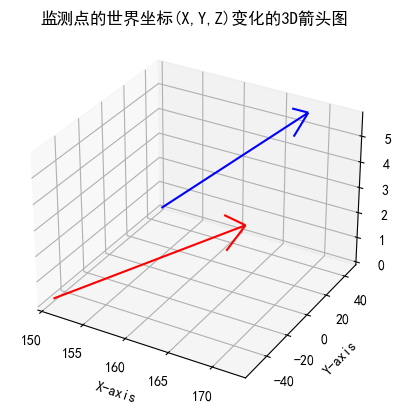

In [80]:
# 创建3D箭头图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 颜色列表
colors = ['red', 'blue', 'green', 'yellow', 'black', 'white',
          'gray', 'cyan', 'magenta', 'orange', 'pink', 'purple', 'brown']

# 绘制箭头
for i, point in enumerate(points):
    x_before, y_before, z_before = point['before']
    x_after, y_after, z_after = point['after']
    dx = x_after - x_before
    dy = y_after - y_before
    dz = z_after - z_before
    ax.quiver(x_before, y_before, z_before, dx, dy,
              dz, color=colors[i % len(colors)], arrow_length_ratio=0.1)
    print(colors[i % len(colors)],"{",point['before'],"--->",point['after'],"}")

# 设置坐标轴标签
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# 设置标题
ax.set_title('监测点的世界坐标(X,Y,Z)变化的3D箭头图')

# 设置坐标轴范围
all_x = [point['before'][0]
         for point in points] + [point['after'][0] for point in points]
all_y = [point['before'][1]
         for point in points] + [point['after'][1] for point in points]
all_z = [point['before'][2]
         for point in points] + [point['after'][2] for point in points]

ax.set_xlim(min(all_x), max(all_x))
ax.set_ylim(min(all_y), max(all_y))
ax.set_zlim(min(all_z), max(all_z))

# 显示图形
plt.show()